<a href="https://colab.research.google.com/github/WesleySouza13/CNN-MINIST-DATASET/blob/main/MNIST_dataset_com_Torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação das bibliotecas


In [ ]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
import torchvision.transforms as transforms


#base de dados

In [ ]:
torch.manual_seed(123)

In [ ]:
transform = transforms.ToTensor() #transformando dados que serão gerados em tensores

In [ ]:
train = datasets.MNIST(root='.', train = True, download=True, transform=transform) #dados de treino


In [ ]:
test = datasets.MNIST(root='.', train = False, download=True, transform=transform) #dados de teste

In [ ]:
train.data[0]

tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,
          18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,   0,   0,   

In [ ]:
train.data.shape

torch.Size([60000, 28, 28])

In [ ]:
train.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [ ]:
train_loader = torch.utils.data.DataLoader(train, batch_size=128) #criação das variaveis de carregamento, tanto em treino tanto em teste
test_loader = torch.utils.data.DataLoader(test, batch_size=128)

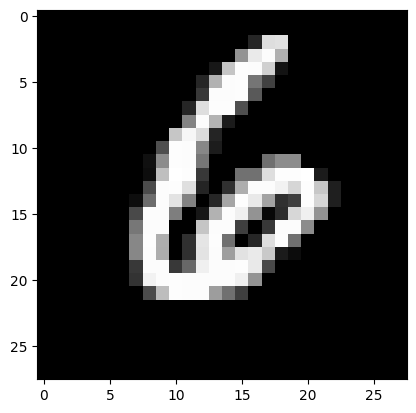

In [ ]:
imagem = next(iter(train_loader))[0][13].view(28,28) #visualizar a imagem do dataset de teste, repare que as dimensoes estão em 28x28, ou seja, há 784 pixels
plt.imshow(imagem, cmap='gray')

In [ ]:
imagem.shape

torch.Size([28, 28])

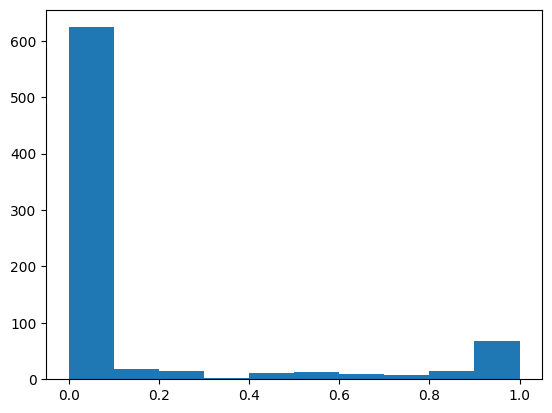

In [ ]:
plt.hist(imagem.view(-1))
plt.show()
#reparamos que os 'pesos' das imagens variam entre 0 e 1

# Construção do modelo

In [ ]:
#criação do modelo

class classificador(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(in_channels=1, out_channels=32,kernel_size=(3,3))
      self.conv2 = nn.Conv2d(32,32,(3,3))
      self.activation = nn.ReLU()
      self.bnorm = nn.BatchNorm2d(num_features=32)
      self.pool = nn.MaxPool2d(kernel_size=(2,2))
      self.flatten = nn.Flatten()

      ##800 -> 128
      ##saida = (entrada - filtro +1/ stride)
      self.linear1 = nn.Linear(32*5*5, out_features=128)
      self.linear2 = nn.Linear(128,128)
      self.output = nn.Linear(128,10)
      self.dropout = nn.Dropout(p=0.2)

    def forward(self, X):
        X = self.pool(self.bnorm(self.activation(self.conv1(X))))
        X = self.pool(self.bnorm(self.activation(self.conv2(X))))
        X = self.flatten(X)

        X = self.dropout(self.activation(self.linear1(X)))
        X = self.dropout(self.activation(self.linear2(X)))
        X = self.output(X)

        return X






In [ ]:
#criterios de erros e otimizador
net = classificador()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters())

# Treinamento do Modelo

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [ ]:
net.to(device)

classificador(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (activation): ReLU()
  (bnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=800, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
def training_loop(loader,epoch):
  running_loss = 0
  running_accuracy = 0

  for i, data in enumerate(loader):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(inputs)

    loss = criterion(outputs,labels)
    loss.backward()

    optimizer.step()

    running_loss += loss.item()
    ###parametros para acuracia
    ps = F.softmax(outputs)
    top_p, top_class = ps.topk(k=1, dim=1)
    equals = top_class == labels.view(*top_class.shape)
    accuracy = torch.mean(equals.type(torch.float))

    running_accuracy += accuracy

    print('\Epoca {:3d} - loop {:3d} de {:3d} perda{:03.2f} - precisao{:03.2f}'.format(epoch +1,i+1, len(loader),loss, accuracy, end = '\r'))

    print('\rEpoca {:3d} finalizada: perda{:.5f} - precisao {:.5f}'.format(epoch + 1, running_loss/len(loader), running_accuracy/len(loader)))


In [ ]:
for epoch in range(5):
  print('treinando...')
  training_loop(train_loader, epoch) #loop de treinanmento com as variaveis de treino
  net.eval()
  print('validando...')
  training_loop(test_loader, epoch) # loop de tesge com as variaveis de teste
  net.train()

treinando...


<ipython-input-75-c8cec2a56747>:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ps = F.softmax(outputs)


A saída de streaming foi truncada nas últimas 5000 linhas.
Epoca   1 finalizada: perda0.13380 - precisao 0.48266
\Epoca   1 - loop 246 de 469 perda0.11 - precisao0.96
Epoca   1 finalizada: perda0.13404 - precisao 0.48471
\Epoca   1 - loop 247 de 469 perda0.14 - precisao0.96
Epoca   1 finalizada: perda0.13433 - precisao 0.48676
\Epoca   1 - loop 248 de 469 perda0.11 - precisao0.98
Epoca   1 finalizada: perda0.13457 - precisao 0.48884
\Epoca   1 - loop 249 de 469 perda0.19 - precisao0.93
Epoca   1 finalizada: perda0.13497 - precisao 0.49082
\Epoca   1 - loop 250 de 469 perda0.09 - precisao0.98
Epoca   1 finalizada: perda0.13517 - precisao 0.49290
\Epoca   1 - loop 251 de 469 perda0.19 - precisao0.97
Epoca   1 finalizada: perda0.13557 - precisao 0.49497
\Epoca   1 - loop 252 de 469 perda0.07 - precisao0.98
Epoca   1 finalizada: perda0.13572 - precisao 0.49707
\Epoca   1 - loop 253 de 469 perda0.08 - precisao0.98
Epoca   1 finalizada: perda0.13588 - precisao 0.49915
\Epoca   1 - loop 254 d

# Avaliação (teste)

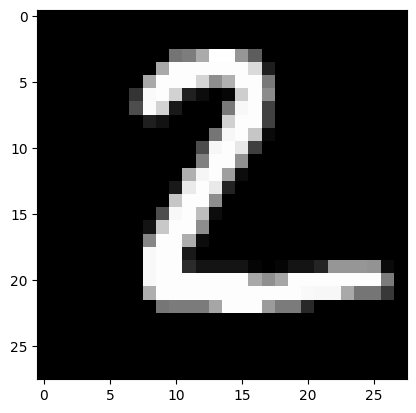

In [ ]:
imagem = next(iter(test_loader))[0][1].view(28,28)
plt.imshow(imagem, cmap='gray')

In [ ]:
imagem.shape

torch.Size([28, 28])

In [ ]:
imagem = imagem.view(1,1,28,28)
imagem.shape

torch.Size([1, 1, 28, 28])

In [ ]:
net.eval()
imagem = imagem.to(device)


In [ ]:
previsao = net.forward(imagem)

In [ ]:
previsao

tensor([[ 1.5809e-01, -1.6183e+00,  1.0172e+01, -4.1030e+00, -3.5197e+00,
         -7.4866e+00, -1.3533e-04, -4.9632e+00, -2.2213e+00, -5.4309e+00]],
       grad_fn=<AddmmBackward0>)

In [ ]:
previsao = F.softmax(previsao)

<ipython-input-106-4836b3525bc1>:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  previsao = F.softmax(previsao)


In [ ]:
previsao

tensor([[4.4766e-05, 7.5763e-06, 9.9990e-01, 6.3149e-07, 1.1317e-06, 2.1424e-08,
         3.8215e-05, 2.6719e-07, 4.1455e-06, 1.6737e-07]],
       grad_fn=<SoftmaxBackward0>)

In [ ]:
previsao = previsao.cpu().detach().numpy()

In [ ]:
previsao

array([[4.4766297e-05, 7.5763469e-06, 9.9990296e-01, 6.3149321e-07,
        1.1316895e-06, 2.1423794e-08, 3.8215057e-05, 2.6718507e-07,
        4.1455214e-06, 1.6737341e-07]], dtype=float32)

In [ ]:
resultado = np.argmax(previsao)

In [ ]:
resultado

2

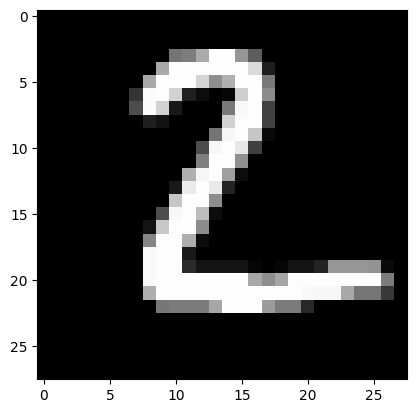



assim como a imagem, o resuldado do modelo deu 2